In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv("marketing_campaign.csv")

In [3]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [4]:
df.shape

(2240, 29)

In [5]:
df['Response'].value_counts()/df.shape[0]

0    0.850893
1    0.149107
Name: Response, dtype: float64

Imbalanced dataset. Target is success of a marketing campaign. Assuming objective is to predict as many positive classes as possible, and not missing any, metric to focus on should be recall. 

## Cleaning the Data for Plotting and Modelling

In [6]:
def data_preprocessor(df):
    df['Income'] = df['Income'].fillna(np.nanmean(df['Income']))
    df = df.drop(['ID','Z_CostContact','Z_Revenue'],axis=1)
    
    #making Education a linear scale: least education 0, most education 4
    edu_enc = {'Basic':0,'2n Cycle':1,'Graduation':2,'Master':3,'PhD':4}
    df['Education'] = df['Education'].replace(edu_enc)
    
    #making Marital_status binary - married or not married (as opposed to almost 6 categories there)
    idx_mar = df['Marital_Status'].loc[df['Marital_Status']=='Married'].index
    idx_nmar = df['Marital_Status'].loc[df['Marital_Status']!='Married'].index

    df.loc[idx_mar,'Marital_Status'] = 1
    df.loc[idx_nmar,'Marital_Status'] = 0
    
    #converting Dt_Customer to time-since-2000-01-01 in days
    df['Dt_Customer']=pd.to_datetime(df['Dt_Customer'],format = '%Y-%m-%d')
    df['Dt_Customer'] = (df['Dt_Customer'] - pd.Timestamp('2000-01-01 00:00:00')).dt.components.days 
    return df   

In [7]:
df = data_preprocessor(df)

In [8]:
cols = df.columns.tolist()
cols.remove('Response')

## Distributions of Variables by Classes

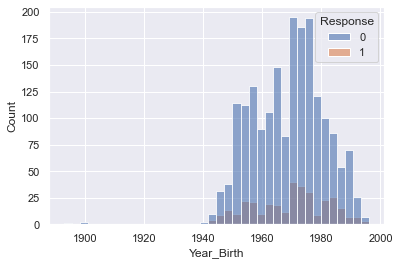

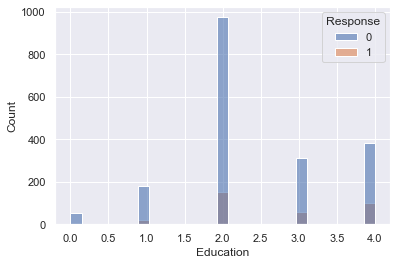

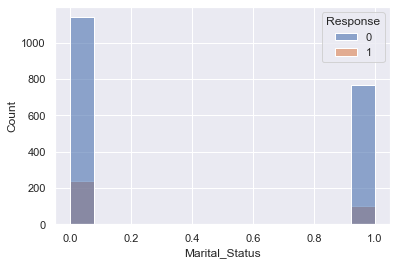

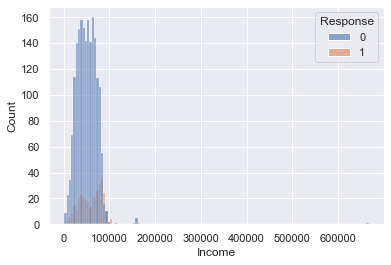

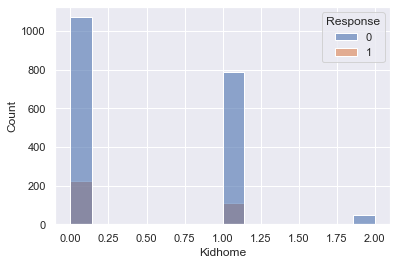

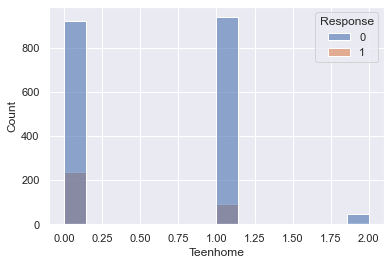

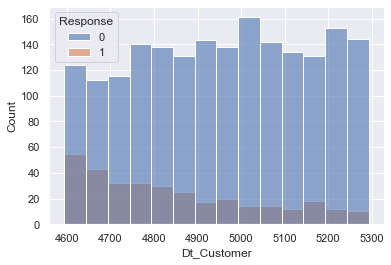

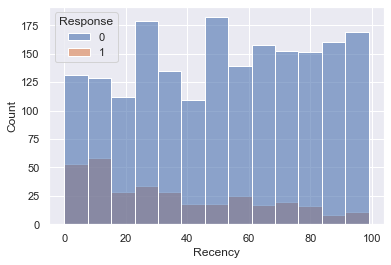

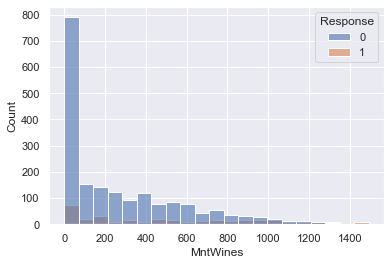

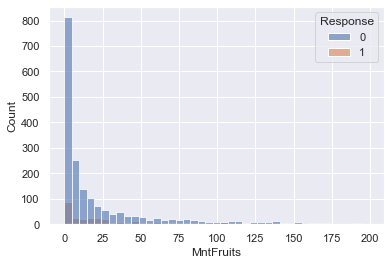

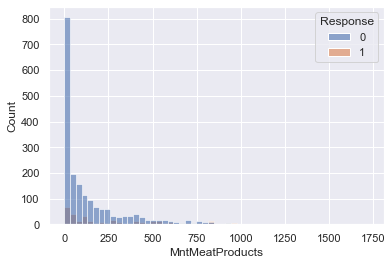

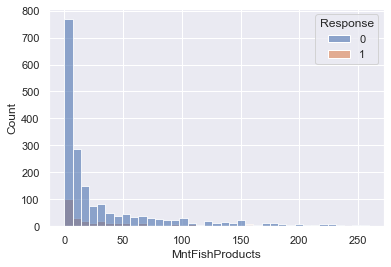

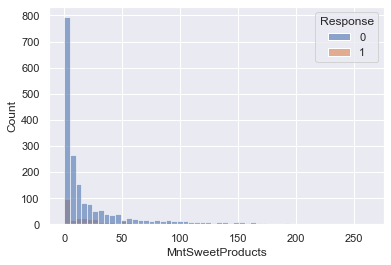

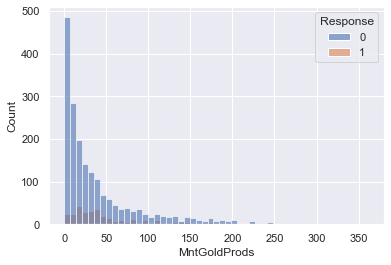

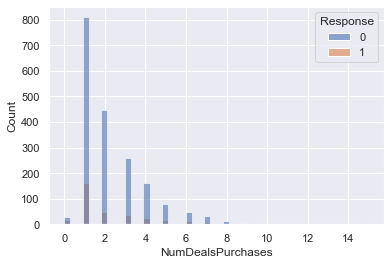

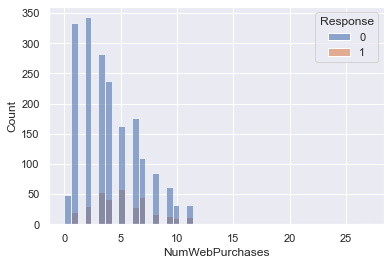

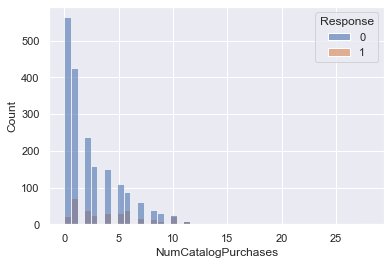

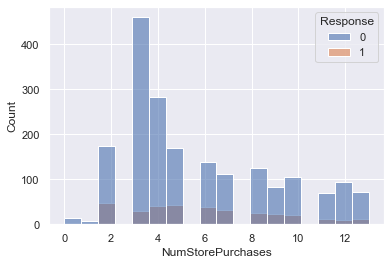

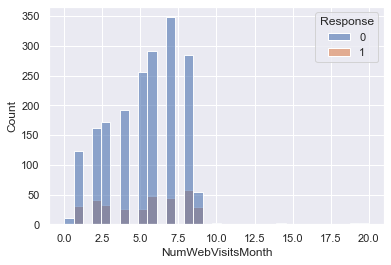

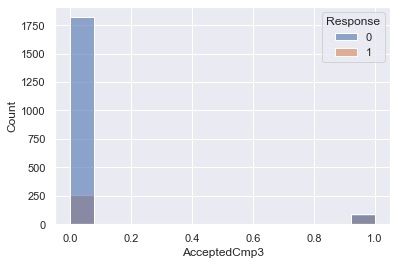

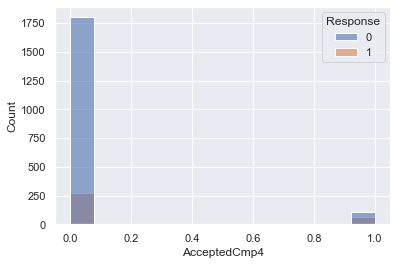

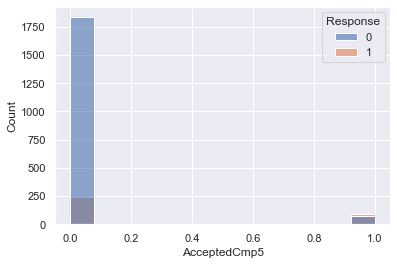

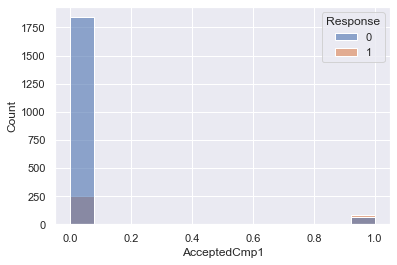

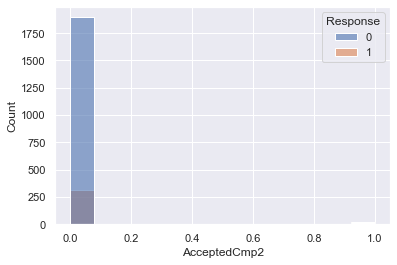

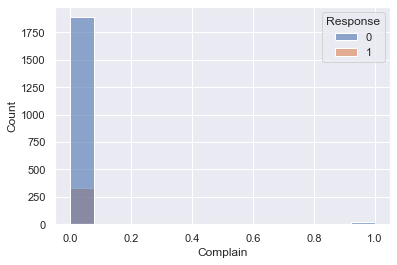

In [9]:
for i in cols:
    sns.histplot(data=df,x=i,hue='Response',alpha=0.6)
    plt.xlabel(i)
    plt.show()

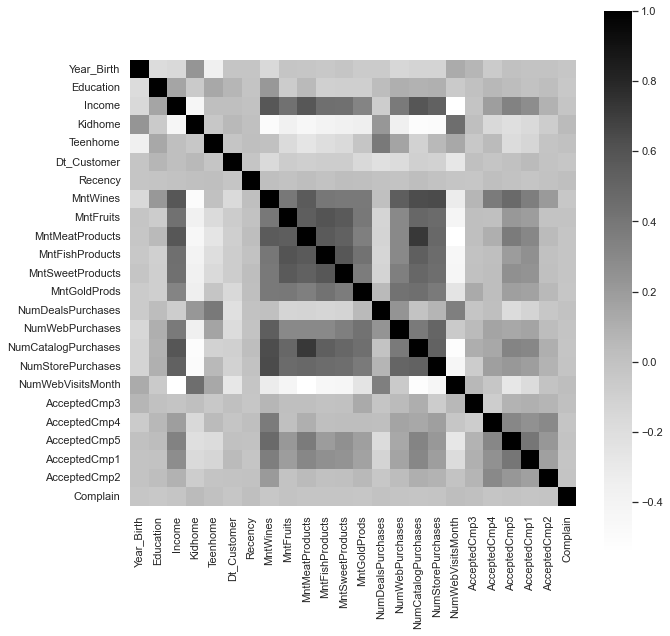

In [10]:
corr = df.drop('Response',axis=1).corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr,square=True,cbar=True,cmap='Greys')
plt.show()

Rorschach's Journal: <br>
I continue to gaze on this data and all I see is skew and imbalanced classes. It's afraid of me. I've seen its true face. The models keep ignoring the minority class and pretend to be accurate. They look up to me and shout "Save us!" ...and I'll look down, and whisper "Recall"

## Preparing Training, Test and Validation data for a NN model

In [11]:
#We'll use a MinMaxScaler - this will leave the binary columns as they are
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

trainX, X_test, trainY, y_test = train_test_split(df.drop('Response',axis=1),df['Response'],test_size=0.2,random_state=3)

scaler = MinMaxScaler()
scaler.fit(trainX)

def data_transformer(X,y):
    return scaler.transform(X),y.to_numpy()

#making validation set
X_train, X_valid, y_train, y_valid = train_test_split(trainX,trainY,test_size=0.2,random_state=2)

X_train, y_train = data_transformer(X_train, y_train)
X_valid, y_valid = data_transformer(X_valid, y_valid)
X_test, y_test = data_transformer(X_test, y_test)

In [12]:
print("Fraction of 1s in training set: %s"%(y_train.sum()/y_train.shape[0]))
print("Fraction of 1s in validation set: %s"%(y_valid.sum()/y_valid.shape[0]))
print("Fraction of 1s in test set: %s"%(y_test.sum()/y_test.shape[0])) 

Fraction of 1s in training set: 0.14166085136078158
Fraction of 1s in validation set: 0.15598885793871867
Fraction of 1s in test set: 0.16741071428571427


## Implementing a NN with early stopping regularization

In [13]:
from sklearn.metrics import accuracy_score, recall_score
import torch
import torch.nn as nn

In [14]:
def to_tensor(X,y):
    Xt = torch.from_numpy(X).to(torch.float)
    yt = torch.from_numpy(y).reshape(-1,1).to(torch.float)
    return Xt, yt

Xt_train, yt_train = to_tensor(X_train, y_train)
Xt_valid, yt_valid = to_tensor(X_valid, y_valid)
Xt_test, yt_test = to_tensor(X_test, y_test)

In [15]:
class NN(nn.Module):
    def __init__(self):
        super(NN,self).__init__()
        self.layers = nn.Sequential(nn.Linear(25,50), nn.ReLU(),
                                    nn.Linear(50,10), nn.ReLU(),
                                    nn.Linear(10,1), nn.Sigmoid())
        
    def forward(self,x):
        return self.layers(x)
    
def train(model, n_epoch, patience, lr, plotloss, plotmetrics, X_train, X_valid, y_train, y_valid):
    
    model.train()
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    printstep = int(n_epoch/10)
    
    last_loss = 100.
    trigger = 0
    
    if(plotloss):
        epoch_loss_train = list()
        epoch_loss_valid = list()
    
    if (plotmetrics):
        epoch_score_train = list()
        epoch_score_valid = list()
        epoch_recall_train = list()
        epoch_recall_valid = list()
    
    for epoch in range(1,n_epoch+1):
        
        optimizer.zero_grad()
        y_pred_train = model(X_train)
        loss = criterion(y_pred_train,y_train)
        loss.backward()
        optimizer.step()
        
        if(epoch%printstep == 0):
            print("Epoch {}, Loss {}".format(epoch,loss.item()))
        
        
        if (plotmetrics):
            epoch_score_train.append(model_accuracy(X_train, y_train))
            epoch_score_valid.append(model_accuracy(X_valid, y_valid))
            epoch_recall_train.append(model_recall(X_train, y_train))
            epoch_recall_valid.append(model_recall(X_valid, y_valid))
        
        #early stopping
        y_pred_valid = model(X_valid)
        loss_valid = criterion(y_pred_valid,y_valid)
        new_loss = loss_valid.item()
        if (plotloss):
            epoch_loss_train.append(loss.item())
            epoch_loss_valid.append(new_loss)
        
        if(new_loss > last_loss):
            trigger += 1
            if(trigger > patience):
                print("Early Stopping at Epoch {}".format(epoch))
                break
        else:
            trigger = 0
        last_loss = new_loss
        
    plt.plot(epoch_loss_train)
    plt.plot(epoch_loss_valid)
    plt.legend(['Training Loss','Validation Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    if(plotmetrics):
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
        ax1.plot(epoch_score_train)
        ax1.plot(epoch_score_valid)
        ax1.set_ylim(0,1)
        ax1.set_xlabel('Epoch')
        ax1.set_title('Accuracy Score')
        
        ax2.plot(epoch_recall_train)
        ax2.plot(epoch_recall_valid)
        ax2.set_ylim(0,1)
        ax2.set_xlabel('Epoch')
        ax2.set_title('Recall Score')
        
        fig.legend(['Training','Validation'])
        plt.show()
    return model

def model_prediction(X):
    y = model(X).detach().numpy()
    y[y>=0.5] = 1
    y[y<0.5] = 0
    return y

def model_accuracy(X,y):
    y_pred = model_prediction(X)
    return accuracy_score(y,y_pred)

def model_recall(X,y):
    y_pred = model_prediction(X)
    return recall_score(y,y_pred)    

def model_scores(X,y):
    print("Accuracy: %s"%model_accuracy(X,y))
    print("Recall:   %s"%model_recall(X,y))

Epoch 100, Loss 0.3185092508792877
Epoch 200, Loss 0.25628575682640076
Epoch 300, Loss 0.2409241795539856
Epoch 400, Loss 0.23357172310352325
Early Stopping at Epoch 483


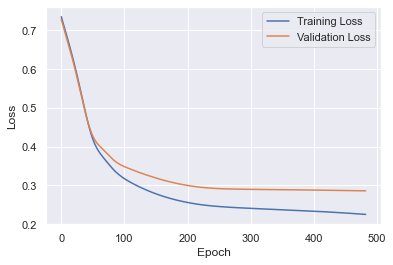

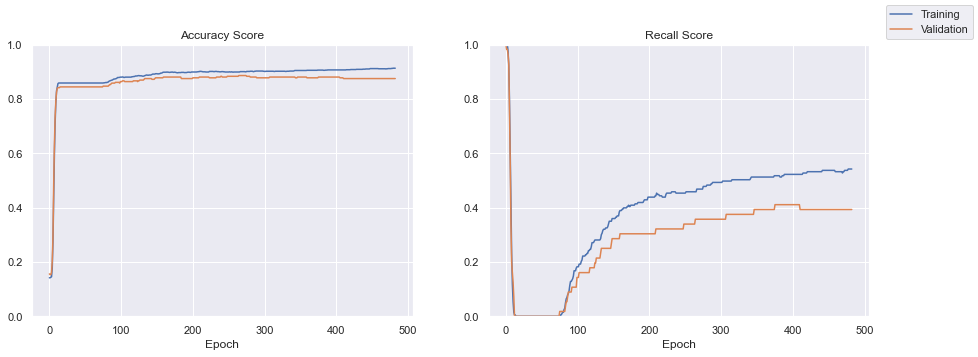

Test Set
Accuracy: 0.8705357142857143
Recall:   0.37333333333333335
Training Set
Accuracy: 0.9127704117236567
Recall:   0.541871921182266
Validation Set
Accuracy: 0.8746518105849582
Recall:   0.39285714285714285


In [16]:
n_epoch = 1000
patience = 2
lr = 0.001
plotloss = True
plotmetrics = True

model = NN()
model = train(model, n_epoch, patience, lr, plotloss, plotmetrics, Xt_train, Xt_valid, yt_train, yt_valid)
print("Test Set")
model_scores(Xt_test, yt_test)
print("Training Set")
model_scores(Xt_train, yt_train)
print("Validation Set")
model_scores(Xt_valid, yt_valid)

### In light of our abysmal performance w.r.t. the recall score, we'll continue training the NN with the positive class (minority class) up-sampled

In [17]:
traindf = pd.concat([trainX,pd.DataFrame(trainY)],axis=1)

n0, n1 = traindf['Response'].value_counts() #number of instances in each class

class0 = traindf[traindf['Response']==0]
class1 = traindf[traindf['Response']==1]

In [18]:
print("Before Resampling")
print("Fraction of Class 1: {}".format(n1/(n0+n1))) #lets boost % of class 1 from 14% to ~40% of total
#taking 4*n1 samples gives ~40% of total

class1over = class1.sample(4*n1,replace=True) 
overdf = pd.concat([class0,class1over],axis=0).sample(frac=1)

print("After Resampling")
print("Fraction of Class 1: {}".format(overdf['Response'].value_counts()[1]/overdf['Response'].value_counts().sum()))

Before Resampling
Fraction of Class 1: 0.14453125
After Resampling
Fraction of Class 1: 0.4032697547683924


In [19]:
#making new training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(overdf.drop('Response',axis=1),overdf['Response'],test_size=0.2,random_state=2)
X_train, y_train = data_transformer(X_train, y_train)
X_valid, y_valid = data_transformer(X_valid, y_valid)

Xt_train, yt_train = to_tensor(X_train, y_train)
Xt_valid, yt_valid = to_tensor(X_valid, y_valid)

### Training continued with oversampled minority class

Early Stopping at Epoch 12


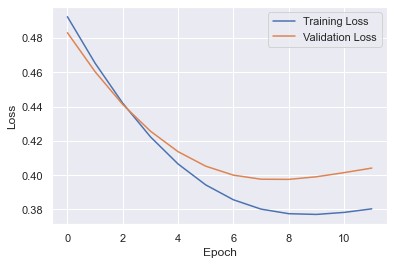

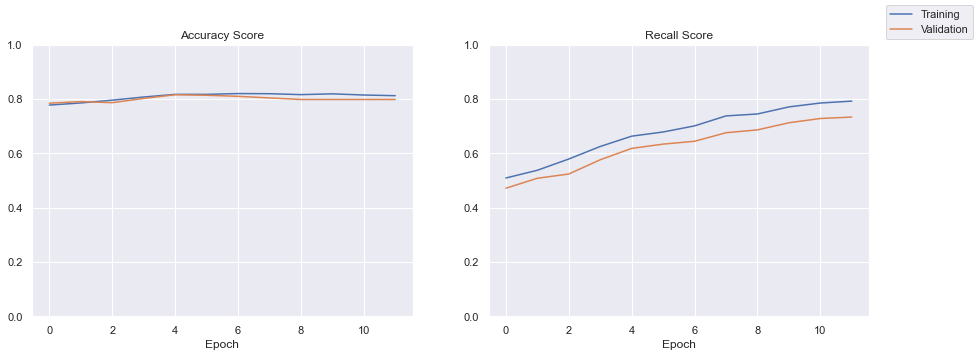

Test Set
Accuracy: 0.8236607142857143
Recall:   0.7333333333333333
Training Set
Accuracy: 0.8116788321167884
Recall:   0.7917159763313609
Validation Set
Accuracy: 0.7976653696498055
Recall:   0.7329842931937173


In [20]:
#continue training model from before
n_epoch = 1000
patience = 2
lr = 0.001
plotloss = True
plotmetrics = True

model = train(model, n_epoch, patience, lr, plotloss, plotmetrics, Xt_train, Xt_valid, yt_train, yt_valid)
print("Test Set")
model_scores(Xt_test, yt_test)
print("Training Set")
model_scores(Xt_train, yt_train)
print("Validation Set")
model_scores(Xt_valid, yt_valid)

#### Recall improved from an abysmal 37% to a respectable 73% (~2x)